In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Here we take height_weight_genders.csv as example.

In [2]:
# Load the data and convert it to metric system
def load_data(subsample=False, add_outlier = True):
    path = 'height_weight_genders.csv'
    data = np.genfromtxt(path, delimiter=',', skip_header=True, usecols=[1,2])
    height = data[:,0]
    weight = data[:,1]
    gender = np.genfromtxt(path, delimiter=',', skip_header=True, usecols=[0],
                          converters={0: lambda x : 1 if b'Male' in x else 0}) # col 0
    height *= 0.025
    weight *= 0.454
    if subsample:
        height = height[::20]
        weight = weight[::20]
    if add_outlier:
        height = np.concatenate([height, [1.1,1.2]])
        weight = np.concatenate([weight, [51.5/0.454, 55.3/0.454]])
    return height, weight, gender

def standerdize(x):
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = (x - x_mean) / x_std
    return x, x_mean, x_std

In [3]:
height, weight, gender = load_data(subsample=False, add_outlier=False)
x, x_mean, x_std = standerdize(height)
y = weight
x_mat = np.c_[np.ones(len(x)),x]

In [14]:
DF = pd.DataFrame({'Height':height,'Weight':weight,'Gender':gender})
print(DF.head().to_string(index=False))

   Height      Weight  Gender
 1.846175  109.819678       1
 1.719548   73.688955       1
 1.852753   96.584348       1
 1.793274   99.899282       1
 1.747045   93.682809       1 (10000, 3)


In [4]:
x_mat

array([[ 1.        ,  1.94406149],
       [ 1.        ,  0.62753668],
       [ 1.        ,  2.01244346],
       ...,
       [ 1.        , -0.64968792],
       [ 1.        ,  0.69312469],
       [ 1.        , -1.14970831]])

# Cost Function

## Mean Square Error

In [5]:
def mse(e):
    return np.mean(e**2)

## Mean Absolute Error

In [6]:
def mae(e):
    return np.mean(np.abs(e))

## Compute Loss

In [14]:
def loss(y, x_mat, w):
    e = y - x_mat.dot(w)
    return mse(e)

# Grid Search

In [49]:
def generate_w(num_intervals):
    w0 = np.linspace(-100,250,num_intervals)
    w1 = np.linspace(-150,120,num_intervals)
    return w0, w1

def grid_search(y, x_mat, w0, w1): #find the lowest loss
    losses = np.zeros((len(w0), len(w1)))
    for i, row in enumerate(w0):
        for j, col in enumerate(w1):
            w = np.array([row, col])
            losses[i, j] = loss(y, x_mat, w)
    return losses

def best_param(w0, w1, losses):
    min_row, min_col = np.unravel_index(np.argmin(losses), losses.shape)
    return losses[min_row, min_col], w0[min_row], w1[min_col]

In [50]:
w0_grid, w1_grid = generate_w(250)
grid_losses = grid_search(y, x_mat, w0_grid, w1_grid)
lowest_loss, w0_best, w1_best = best_param(w0_grid, w1_grid, grid_losses)
print('Grid Search: loss*={l}, w0*={w0}, w1*={w1}'.format(l=lowest_loss, w0=w0_best, w1=w1_best))

Grid Search: loss*=30.998806863732035, w0*=72.89156626506022, w1*=13.734939759036138


In [41]:
grid_losses.T

array([[75635.14279993, 75288.17108514, 74943.21546685, ...,
        51184.15745377, 51335.16157807, 51488.18179888],
       [75122.1854438 , 74775.213729  , 74430.25811072, ...,
        50671.20009763, 50822.20422193, 50975.22444275],
       [74612.13126664, 74265.15955184, 73920.20393356, ...,
        50161.14592048, 50312.15004478, 50465.17026559],
       ...,
       [37136.15645563, 36789.18474083, 36444.22912254, ...,
        12685.17110946, 12836.17523376, 12989.19545457],
       [37340.28430779, 36993.31259299, 36648.35697471, ...,
        12889.29896163, 13040.30308593, 13193.32330674],
       [37547.31533894, 37200.34362414, 36855.38800586, ...,
        13096.32999277, 13247.33411707, 13400.35433789]])

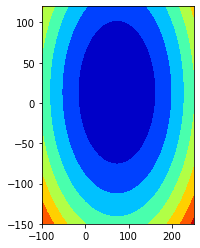

In [51]:
w0, w1 = np.meshgrid(w0_grid, w1_grid)
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
cp = ax1.contourf(w0, w1, grid_losses.T, cmap = plt.cm.jet)


In [32]:
w0

array([[-100.        ,  -98.99598394,  -97.99196787, ...,  147.99196787,
         148.99598394,  150.        ],
       [-100.        ,  -98.99598394,  -97.99196787, ...,  147.99196787,
         148.99598394,  150.        ],
       [-100.        ,  -98.99598394,  -97.99196787, ...,  147.99196787,
         148.99598394,  150.        ],
       ...,
       [-100.        ,  -98.99598394,  -97.99196787, ...,  147.99196787,
         148.99598394,  150.        ],
       [-100.        ,  -98.99598394,  -97.99196787, ...,  147.99196787,
         148.99598394,  150.        ],
       [-100.        ,  -98.99598394,  -97.99196787, ...,  147.99196787,
         148.99598394,  150.        ]])

# Gradient Descent
## Gradient
Suppose $y \approx f(x) = w_0+w_1x$  
$error = y-\mathbf{X}w$  
Here we take MSE as examples:  
$L = \frac{\sum (y-\mathbf{X}w)^2}{n}$  
then the gradient of the cost is:  
$\Delta L = \frac{\partial L}{\partial w} = -\frac{2}{n}\mathbf{X}^Te$

## Gradient Descent
$w^{k+1} = w^k - \tau \Delta L(w^k)$

In [30]:
def grad(y, x_mat, w):
    err = y - x_mat.dot(w)
    grad = -2*x_mat.T.dot(err) / len(err)
    return grad, err

def gradient_descent(y, x_mat, tau, w_init, max_iter):
    w_ = [w_init]
    losses = []
    w = w_init
    for i in range(max_iter):
        gradient, err = grad(y, x_mat, w)
        loss = mse(err)
        w = w - tau * gradient
        w_.append(w)
        losses.append(loss)
        #print('Gradient Descent Iteration ({a}/{b}) : loss = {l}, w0 = {w0}, w1 = {w1}'.format(
         #       a = i+1, b = max_iter, l = loss, w0=w[0], w1=w[1]))
    return losses, w_

In [46]:
w = np.array([10,20]).reshape(2,-1)
y = np.array([20,26,17,14,16,19,14,28,25,22]).reshape(10,1)
x = np.random.randn(10,2)+2
gradient_descent(y, x, 0.01, w, 20)[0]

[2041.6862728588699,
 1397.4853606363195,
 965.299286561489,
 675.3035059403763,
 480.6703301192994,
 349.9948450092105,
 262.215375802553,
 203.20691168891716,
 163.49649622776266,
 136.73106065870883,
 118.64988083458232,
 106.39545848946076,
 98.05136578277487,
 92.3323020911869,
 88.37623149304034,
 85.60498036669965,
 83.63074756149348,
 82.19340569962459,
 81.11845245909765,
 80.28881070554817]

# Stochastic Gradient Descent
ref : https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/  
ref : https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a


In [79]:
def butches_generator(y, x_mat, batch_size, num_batches, shuffle=True):
    n = len(y)
    if shuffle:
        shuffle_indices = np.random.permutation(n)
        shuffled_y = y[shuffle_indices]
        shuffled_xmat = x_mat[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_xmat = x_mat
    
    for num_batch in range(num_batches):
        start_index = num_batch * batch_size
        end_index = min((num_batch + 1) * batch_size, n)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_xmat[start_index:end_index]

def grad_stoch(y, x_mat, w):
    err = y - x_mat.reshape(len(y),-1).dot(w)
    grad = -2*x_mat.reshape(len(y),-1).T.dot(err) / len(err)
    return grad, err

In [94]:
x = np.array([[1,2,3,4,5,6,7,8,9,10],[6,7,11,2,6,8,4,2,6,9]]).reshape(10,2)
y = np.array([45,73,45,34,21,16,36,41,34,12])
a = butches_generator(y, x, 2, 5)
next(a)

(array([45, 36]), array([[ 1,  2],
        [11,  2]]))

In [91]:
def MiniBatch_Gradient_Descent(y, x_mat, w_init, batch_size, num_batches, epochs, tau):
    w = w_init
    losses = []
    w_ = [w_init]
    for iter in range(epochs):
        butches = butches_generator(y, x_mat, batch_size, num_batches)
        batch_y, batch_x = next(butches)
        n = len(batch_y)
        gradients = []
        for i in range(n):
            gradient, err = grad_stoch(batch_y[i], batch_x[i], w)
            gradients.append(gradient)
            gradient_update = np.mean(gradients)
        w = w - tau * gradient_update
        error = y - x_mat.dot(w)
        loss = mse(error)
        w_.append(w)
        losses.append(loss)
        #print('MiniBatch_Gradient_Descent epoch ({a}/{b}) : loss = {l}, w = {w}'.format(
         #       a = iter+1, b = epochs, l = loss, w = w))
    return losses, w_
            

In [93]:
w = np.array([10,20]).reshape(2,-1)
y = np.array([20,26,17,14,16,19,14,28,25,22]).reshape(10,1)
x = np.random.randn(10,2)+2
MiniBatch_Gradient_Descent(y, x, w, 4, 5, 10, 0.01)

([1111.8534243759527,
  783.5267263168588,
  458.6630214245767,
  357.92484591468025,
  304.4403063958374,
  250.9456094723912,
  195.04741000823861,
  157.8245486937935,
  140.64341590054576,
  125.67555868502488],
 [array([[10],
         [20]]), array([[ 8.46838907],
         [18.46838907]]), array([[ 7.04284321],
         [17.04284321]]), array([[ 5.21976619],
         [15.21976619]]), array([[ 4.48532026],
         [14.48532026]]), array([[ 4.03249695],
         [14.03249695]]), array([[ 3.51045849],
         [13.51045849]]), array([[ 2.83969597],
         [12.83969597]]), array([[ 2.24989306],
         [12.24989306]]), array([[ 1.89114604],
         [11.89114604]]), array([[ 1.46762209],
         [11.46762209]])])